In [98]:
import pandas as pd
import zipfile, os
import numpy as np
import csv
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL

In [99]:
# Specify the path to your CSV file
!wget https://raw.githubusercontent.com/Danazzz/dataset-beras-scm/master/csv/Beras.csv

df_beras = pd.read_csv('Beras.csv')
df_beras

--2024-06-04 16:48:49--  https://raw.githubusercontent.com/Danazzz/dataset-beras-scm/master/csv/Beras.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42658 (42K) [text/plain]
Saving to: ‘Beras.csv.4’

Beras.csv.4         100%[===================>]  41.66K  --.-KB/s    in 0.02s   

2024-06-04 16:48:50 (2.62 MB/s) - ‘Beras.csv.4’ saved [42658/42658]



,Tanggal,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Harga Beras Penggilingan,Produksi Beras,Harga Beras,UMP,BBM Solar,Tingkat Konsumsi
0,2021-03-15,10,4000,4150,5050,9465,14419,11200,4960,9600,17161
1,2021-03-16,10,3850,4100,4740,9360,14419,11200,4960,9600,17161
2,2021-03-17,10,4160,4230,4950,9400,14419,11200,4960,9600,17161
3,2021-03-18,10,4120,4190,4730,9340,14419,11200,4960,9600,17161
4,2021-03-19,10,4190,4290,4990,9410,14419,11200,4960,9600,17161
...,...,...,...,...,...,...,...,...,...,...,...
673,2023-12-21,30,6770,6850,7980,13100,14391,14000,5444,6800,17598
674,2023-12-22,30,6600,6760,8050,13095,14391,14000,5444,6800,17598
675,2023-12-27,30,6620,6760,8030,13120,14391,14000,5444,6800,17598
676,2023-12-28,30,6650,6760,8020,13120,14391,14000,5444,6800,17598


In [100]:
df_beras.drop(['Tanggal'], axis = 1, inplace = True)

In [101]:
df_beras_trend = pd.DataFrame()
df_beras_seasonal = pd.DataFrame()
df_beras_resid = pd.DataFrame()

for series_name, series in df_beras.items():
  stl = STL(df_beras[series_name], period=12, robust=True)
  result = stl.fit()
  df_beras_trend[series_name] = result.trend
  df_beras_seasonal[series_name] = result.seasonal
  df_beras_resid[series_name] = result.resid

In [102]:
def data_to_X_y(df):
  X = df.drop('Harga Beras', axis=1)
  y = df['Harga Beras']

  return X, y

X_trend, y_trend = data_to_X_y(df_beras_trend)
X_seasonal, y_seasonal = data_to_X_y(df_beras_seasonal)
X_resid, y_resid = data_to_X_y(df_beras_resid)

In [103]:
def splitting_data(df, X, y):
  cutoff_index = int(len(df) * 0.8)

  # Split the dataset into training and testing sets using the calculated index
  X_train = X.iloc[:cutoff_index]
  X_test = X.iloc[cutoff_index:]
  y_train = y.iloc[:cutoff_index]
  y_test = y.iloc[cutoff_index:]

  return X_train, X_test, y_train, y_test

X_train_trend, X_test_trend, y_train_trend, y_test_trend = splitting_data(df_beras_trend, X_trend, y_trend)
X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal = splitting_data(df_beras_seasonal, X_seasonal, y_seasonal)
X_train_resid, X_test_resid, y_train_resid, y_test_resid = splitting_data(df_beras_resid, X_resid, y_resid)

In [104]:
y_test_trend

542    12421.356847
543    12421.606565
544    12421.840766
545    12421.959867
546    12421.924810
           ...     
673    14005.235914
674    14009.459858
675    14013.683879
676    14017.907883
677    14022.131474
Name: Harga Beras, Length: 136, dtype: float64

In [105]:
from sklearn.preprocessing import MinMaxScaler
# trend_scaler = MinMaxScaler()
# seasonal_scaler = MinMaxScaler()
# resid_scaler = MinMaxScaler()
X_trend_scaler = MinMaxScaler()
y_trend_scaler = MinMaxScaler()
X_seasonal_scaler = MinMaxScaler()
y_seasonal_scaler = MinMaxScaler()
X_resid_scaler = MinMaxScaler()
y_resid_scaler = MinMaxScaler()

# def scaling_data(scaler, X_train, X_test, y_train, y_test):
#   X_train = scaler.fit_transform(np.array(X_train))
#   X_test = scaler.transform(np.array(X_test))

#   y_train = scaler.fit_transform(np.array(y_train).reshape(-1,1))
#   y_test = scaler.transform(np.array(y_test).reshape(-1,1))

#   return X_train, X_test, y_train, y_test

def X_scaling_data(scaler, X_train, X_test):
  X_train = scaler.fit_transform(np.array(X_train))
  X_test = scaler.transform(np.array(X_test))
  return X_train, X_test

def y_scaling_data(scaler, y_train, y_test):
  y_train = scaler.fit_transform(np.array(y_train).reshape(-1,1))
  y_test = scaler.transform(np.array(y_test).reshape(-1,1))
  return y_train, y_test

# X_train_trend, X_test_trend, y_train_trend, y_test_trend = scaling_data(trend_scaler, X_train_trend, X_test_trend, y_train_trend, y_test_trend)
# X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal = scaling_data(seasonal_scaler, X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal)
# X_train_resid, X_test_resid, y_train_resid, y_test_resid = scaling_data(resid_scaler, X_train_resid, X_test_resid, y_train_resid, y_test_resid)
X_train_trend, X_test_trend = X_scaling_data(X_trend_scaler, X_train_trend, X_test_trend)
y_train_trend, y_test_trend = y_scaling_data(y_trend_scaler, y_train_trend, y_test_trend)
X_train_seasonal, X_test_seasonal = X_scaling_data(X_seasonal_scaler, X_train_seasonal, X_test_seasonal)
y_train_seasonal, y_test_seasonal = y_scaling_data(y_seasonal_scaler, y_train_seasonal, y_test_seasonal)
X_train_resid, X_test_resid = X_scaling_data(X_resid_scaler, X_train_resid, X_test_resid)
y_train_resid, y_test_resid = y_scaling_data(y_resid_scaler, y_train_resid, y_test_resid)

In [107]:
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression()

In [108]:
def modelling_data(X_train, y_train):
  lin_model.fit(X_train, y_train)

  return lin_model

model_trend = modelling_data(X_train_trend, y_train_trend)
model_seasonal = modelling_data(X_train_seasonal, y_train_seasonal)
model_resid = modelling_data(X_train_resid, y_train_resid)

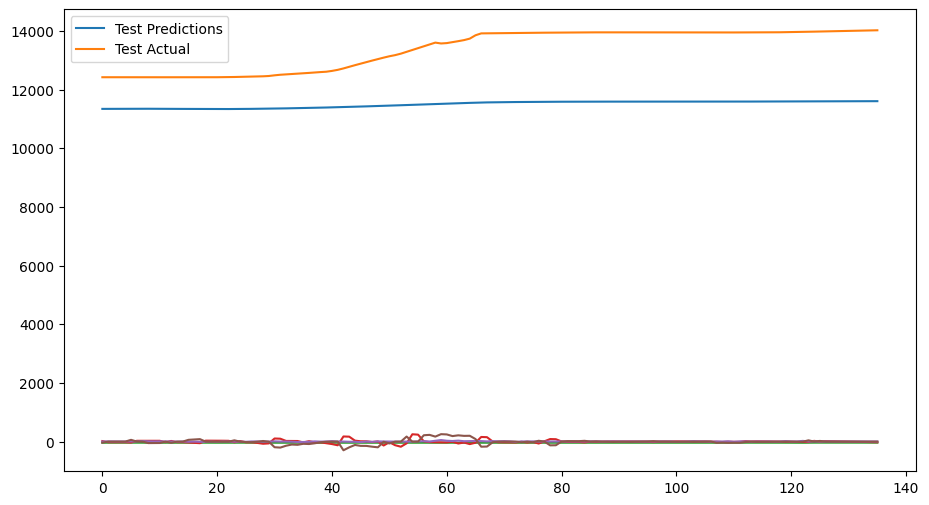

In [115]:
def predicting_data(scaler, lin_model, X_test, y_test):
  lin_pred=lin_model.predict(X_test)
  lin_pred_inv = scaler.inverse_transform(lin_pred.reshape(-1,1))

  plt.plot(lin_pred_inv)
  plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
  plt.legend(['Test Predictions', 'Test Actual'])

  # plt.rcParams["figure.figsize"] = (11,6)
  # # lin_pred_inv = scaler.inverse_transform(lin_pred.reshape(-1,1))
  # plt.plot(lin_pred,label='Linear_Regression_Predictions')
  # plt.plot(y_test,label='Actual Sales')
  # plt.legend(loc="upper left")
  # plt.show()

  return lin_pred_inv

predict_trend = predicting_data(trend_scaler, model_trend, X_test_trend, y_test_trend)
predict_seasonal = predicting_data(seasonal_scaler, model_seasonal, X_test_seasonal, y_test_seasonal)
predict_resid = predicting_data(resid_scaler, model_resid, X_test_resid, y_test_resid)

In [116]:
data_predict_jumlah = predict_trend + predict_seasonal + predict_resid
data_predict_jumlah

array([[11305.08185075],
       [11312.64049056],
       [11311.89787337],
       [11313.03200423],
       [11312.36431143],
       [11315.28632597],
       [11314.32709144],
       [11326.05099535],
       [11316.53955193],
       [11313.37343229],
       [11314.77449093],
       [11312.45731256],
       [11310.70415093],
       [11303.85875943],
       [11307.59707225],
       [11299.27218741],
       [11301.78228771],
       [11293.87903765],
       [11291.87510791],
       [11298.11528832],
       [11289.53566134],
       [11302.98131002],
       [11298.07900611],
       [11301.5844317 ],
       [11298.2430664 ],
       [11295.88108709],
       [11308.60750502],
       [11312.54680914],
       [11308.29904397],
       [11312.669419  ],
       [11323.62648501],
       [11318.31247398],
       [11322.74674318],
       [11322.16725048],
       [11315.5546749 ],
       [11319.30824983],
       [11332.87971341],
       [11348.70811592],
       [11342.76376286],
       [11356.3848945 ],


In [117]:
y_test_trend_scaler_inverse = trend_scaler.inverse_transform(y_test_trend.reshape(-1,1))
y_test_seasonal_scaler_inverse = seasonal_scaler.inverse_transform(y_test_seasonal.reshape(-1,1))
y_test_resid_scaler_inverse = resid_scaler.inverse_transform(y_test_resid.reshape(-1,1))
y_test_asli = y_test_trend_scaler_inverse + y_test_seasonal_scaler_inverse + y_test_resid_scaler_inverse
y_test_asli

array([[12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12450.],
       [12450.],
       [12450.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12450.],
       [12450.],
       [12450.],
       [12500.],
       [12500.],
       [12550.],
       [12550.],
       [12550.],
       [12550.],
       [12600.],
       [12750.],
       [12750.],
       [12750.],
       [12800.],
       [12800.],
       [12850.],
       [12950.],
       [13050.],
       [13050.],
       [13050.],
       [13400.],
       [13600.],
       [13650.],
       [13700.],
       [13750.],
       [13750.

In [119]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(data_predict_jumlah,y_test_asli))
mae = mean_absolute_error(data_predict_jumlah,y_test_asli)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# R Square
r = r2_score(data_predict_jumlah,y_test_asli)

# Mean Magnitude of Relative Error
mmre = (abs((data_predict_jumlah - y_test_asli) / y_test_asli)).mean()

# Median Magnitude of Relative Error
mdmre = np.median(abs((data_predict_jumlah - y_test_asli) / y_test_asli))

# Mean Magnitude of Error Relative
mmer = (abs(data_predict_jumlah - y_test_asli)).mean()

# Mean Square Error
mse = mean_squared_error(data_predict_jumlah, y_test_asli)

# Menampilkan hasil
print("R Square: {:.4f}".format(r))
print("Mean Magnitude of Relative Error: {:.4f}".format(mmre))
print("Median Magnitude of Relative Error: {:.4f}".format(mdmre))
print("Mean Magnitude of Error Relative: ", mmer)
print("Mean Square Error:", mse)

Root Mean Square Error: 1997.0707262591627
Mean Absolute Error: 1909.9853918906272
R Square: -331.5563
Mean Magnitude of Relative Error: 0.1409
Median Magnitude of Relative Error: 0.1687
Mean Magnitude of Error Relative:  1909.9853918906272
Mean Square Error: 3988291.4856812996
